![Glory Arstotzka](./assets/first-image.png)

# WELCOME to QPapersPlease

This is an exercise that I've done to learn more about quantum computing, quantum algorithms and quantum games, so, probably, you can find other ways to do these algorithms in a more precise and reliable way, but, as an exercise, I think that's good🤷‍♂️\
This project, for sure, is inspired by the indie game, Papers please. In this game, you are an immigranting officer of a fictional country called Arstotzka. Each day you have some rules for what entraces must pass, and you need to use this rules to check and find discrepancies that could lead to some problems later. To know more, go to [the official website](https://papersplea.se/).

To start here, make sure that I've installed all the required dependencies from `Pipfile` or `requirements.txt`! Also, create a `.env` and set the variable `IBM_API_TOKEN` to your [IBM quantum](https://quantum-computing.ibm.com/) token, in case you want to run some code in a real quantum machine. 

### After all, let's start the code!

In [1]:
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, Aer, transpile, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
import os

shots = 1000

In [16]:
# run this cell if you'll want to run the circuit in an IBMQ quantum computer
from qiskit_ibm_provider import IBMProvider
from dotenv import load_dotenv
load_dotenv()
IBMProvider.save_account(token=os.getenv('IBM_API_TOKEN'), overwrite=True)
provider = IBMProvider()
ibm_backend = provider.get_backend('ibmq_lima')

---

# Generate data

Here, we have the algorithm to generate the input data (or, if you prefer, the entrance data).
It's based on Bloch sphere rotations to roughly embed the probability to get the state $|1⟩$ using this general equation:

> $ θ = \arcsin {\sqrt {b} \over 10} * 2 $

where $b$ is the percentage of probability to get $|1⟩$ and $θ$ is the final rotation that we can put in a $RY$ gate.


To test this aproach, let's use some probabilties

- Documents: 70% false and 30% true

- False info: 60% false and 40% true

- Wanted: 95% false and 5% true

- Bribe: 90% false and 10% true

In [19]:
qubits = ["all_documents", "false_info", "wanted", "bribe"]
percentages_of_true = [30, 40, 5, 10]
get_theta = lambda B: np.arcsin(B) * 2

for qubit, percentage in zip(qubits, percentages_of_true):
    #a = cos(theta/2)
    #B = e^(i phi) sin(theta/2)

    B = np.sqrt(percentage)/10
    theta = get_theta(B)
    a = np.cos(theta/2)
    
    print('-'*50)
    print(qubit.upper())
    print(f'theta: {theta}')
    print(f'a --> {a}')
    print(f'B --> {B}')
    print(f'a+B prob --> {np.round(a**2+B**2)}')

--------------------------------------------------
ALL_DOCUMENTS
theta: 1.1592794807274085
a --> 0.8366600265340756
B --> 0.5477225575051661
a+B prob --> 1.0
--------------------------------------------------
FALSE_INFO
theta: 1.369438406004566
a --> 0.7745966692414834
B --> 0.6324555320336759
a+B prob --> 1.0
--------------------------------------------------
WANTED
theta: 0.4510268117962625
a --> 0.9746794344808963
B --> 0.223606797749979
a+B prob --> 1.0
--------------------------------------------------
BRIBE
theta: 0.6435011087932844
a --> 0.9486832980505138
B --> 0.31622776601683794
a+B prob --> 1.0


Using this aproach, you see that the sum of the probabilities from $a$ and $B$ are equal to 1, so we get the correct total probability and it's a valid way to encode each data qubit.

To be a little simpler to encode this, let's create a class to do this automatically. 

In [15]:
class Inputs:
    def __init__(self, *args, probabilities):
        self.total_qubits = len(args)
        
        assert len(probabilities) == self.total_qubits, "different sizes of probabilities and qubits"
        
        self.probabilities = probabilities
        self.circuit = QuantumCircuit(*args)
        
    def prepare(self):
        self.bind_probabilities()
        
    def bind_probabilities(self):
        for qubit, probability in enumerate(self.probabilities):
            self.bin_theta_from_probability(qubit, probability)
    
    def bin_theta_from_probability(self, qubit, probability):
        beta = np.sqrt(probability)/10
        theta = np.arcsin(beta)*2
        self.circuit.ry(theta, qubit)
        
    def show(self):
        display(self.circuit.draw('mpl'))
        
    def add_measurement(self):
        self.circuit.measure_all()
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=shots):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
    
    def get_circuit(self):
        return self.circuit

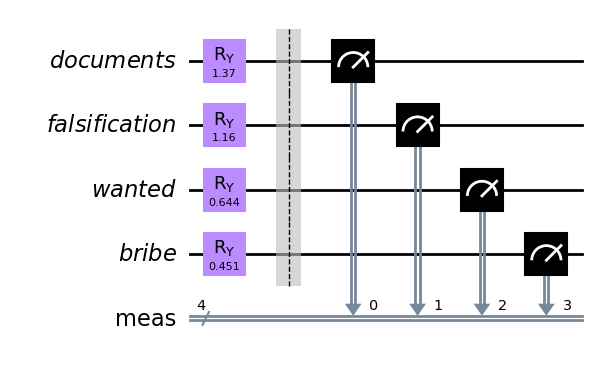

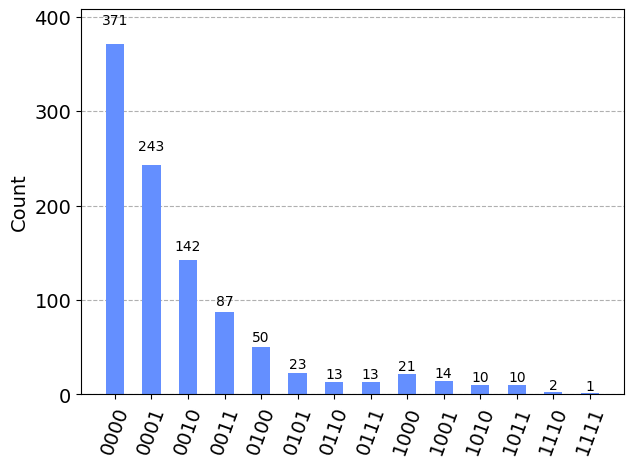

In [17]:
all_documents = QuantumRegister(1, name="documents")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")

inputs = Inputs(all_documents, false_info, wanted, bribe, probabilities=[40, 30, 10, 5])
inputs.prepare()
inputs.add_measurement()
inputs.show()
results = inputs.measure()
#results = inputs.measure(backend=ibm_backend) #use this to run on IBMQ

In [27]:
get_percentage = lambda total, x: (x/total)*100

def evaluate_results(shots, qubits, results):
    totals = { qubit:0 for qubit in qubits }
    qubits = qubits[::-1]
    
    for bit_string, total in list(results.items()):
        for qubit, value in enumerate(bit_string):
            if(value == '1'):
                totals[qubits[qubit]] += total
                
    for qubit, total in list(totals.items()):
        print(f'{qubit} ~{np.round(get_percentage(shots, total))}%')

evaluate_results(shots, ['all_documents', 'false_info', 'wanted', 'bribe'], results['results'])
    

all_documents ~39.0%
false_info ~28.0%
wanted ~10.0%
bribe ~6.0%


---

# Oracle circuit (Check circuit)

Now that we can encode the data, we need to check if the data is correct or not!\
To do that, we can use the Bernstein Vazirani circuit, which a hidden string is put inside an oracle and querying it we can get the hidden String that's inside in just 1 query.\
Using this idea, we can embed some game rules inside an oracle and then query it to get the response. In this setup, if the resulting bit string is $|1⟩^{⊗N}$, where $N$ is each qubit so we have the correct input, or, in this context, the entrance could pass.

In [29]:
class Check:
    def __init__(self, *args):
        self.total_data_qubits = len(args)
        self.total_qubits = self.total_data_qubits+1
        
        self.phase_qubit = AncillaRegister(1, name="ancilla")
        self.circuit = QuantumCircuit(self.phase_qubit, *args)
        
        self.circuit_measurement = QuantumCircuit(self.total_qubits, self.total_data_qubits)
        self.circuit_measurement.measure(range(1, self.total_qubits), range(self.total_data_qubits))
        
    def add_input(self, bit_string):
        assert len(bit_string) == self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
    
        for qubit, bit in enumerate(bit_string):
            if(bit == '1'):
                self.circuit.x(qubit+1)
        self.add_barrier()
        
    def parse_bit_string(self, bit_string):
        return bit_string[::-1]
        
    def add_barrier(self):
        self.circuit.barrier()
    
    def prepare(self, bit_string, show_oracle=False, show_state_vector=False):
        self.add_oracle(bit_string, show_oracle)
        if(show_state_vector):
            self.show_state_vector()
            
    def add_oracle(self, bit_string, show_oracle):
        assert len(bit_string) <= self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
        qubits_iterator = range(self.total_qubits)
        
        oracle = QuantumCircuit(self.total_qubits, name="Oracle")
        
        oracle.x(0)
        oracle.h(qubits_iterator)
        
        for qubit, bit in enumerate(bit_string): 
            if(bit == '0'):
                oracle.cx(qubit+1, 0)
                
        oracle.h(qubits_iterator)
        
        if(show_oracle): 
            display(oracle.draw('mpl'))
        
        self.circuit.append(oracle, qubits_iterator)
        
    def show_state_vector(self):
        display(Statevector(self.circuit).draw('latex'))
        
    def add_measurement(self):
        self.circuit.compose(self.circuit_measurement, inplace=True)
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
    
    def show(self):
        display(self.circuit.draw("mpl"))
        
    def get_circuit(self):
        return self.circuit
        

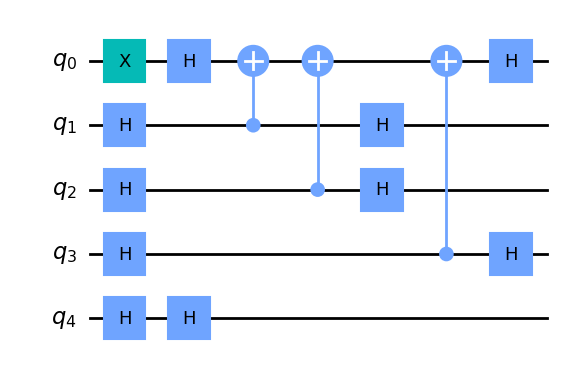

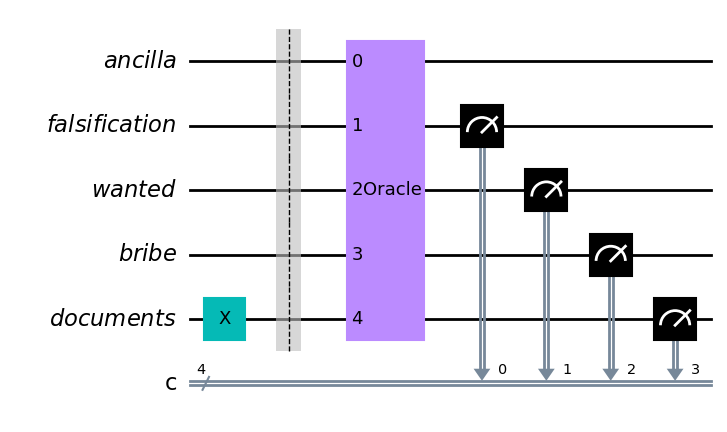

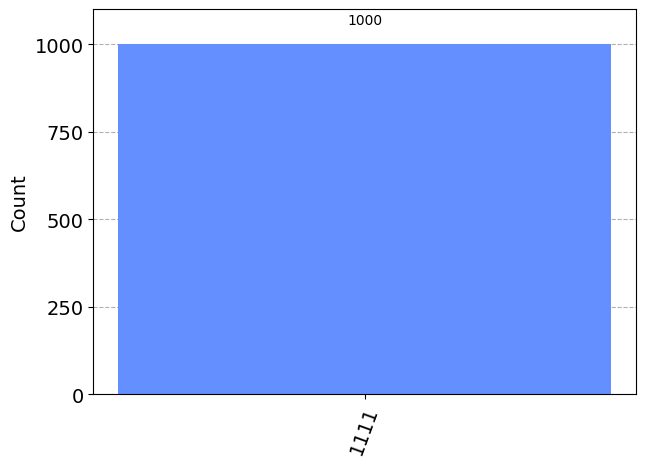

In [31]:
data = [false_info, wanted, bribe, all_documents]
checker = Check(*data)
checker.add_input("1000") #set the query
checker.prepare(bit_string="1000", show_oracle=True)# set hidden_string
checker.add_measurement()
checker.show()
results = checker.measure()
#results = inputs.measure(backend=ibm_backend) #use this to run on IBMQ

In [32]:
def show_results(shots, result):
    get_percentage = lambda total, x: (x/total)*100
    ordered_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    if(not '0' in list(ordered_result.keys())[0]):
        print('Recieved the correct result!!!')
    else:
        print('The result is Incorrect!!!')        
    
    print('-'*50)
    
    print("string - total - percentage")
    for bit_string, total in list(ordered_result.items()):
        print(f'{bit_string}     {total}    {int(get_percentage(shots, total))}%')
        
total_shots = measurement_result['shots']
result = measurement_result['results']
show_results(total_shots, result)

Recieved the correct result!!!
--------------------------------------------------
string - total - percentage
1111     1000    100%


---

# Putting all together

With those two algorithms, we can put them along and generate the distribution of entraces that have passed

In [33]:
class QPP:
    def __init__(self, *args, generator, checker):
        self.generator = generator
        self.checker = checker
        
        phase = AncillaRegister(1, name="ancilla")
        self.output = ClassicalRegister(len(args), name="out")
        self.data_qubits_indexes = list(range(1, len(args)+1))
        
        self.circuit = QuantumCircuit(phase, *args, self.output)
        self.circuit.compose(generator, inplace=True, qubits=self.data_qubits_indexes)
        self.circuit.barrier()
        self.circuit.compose(checker, inplace=True)
    
    def add_measurement(self):
        self.circuit.measure(self.data_qubits_indexes, self.output)
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
        
    def show(self):
        display(self.circuit.draw('mpl'))

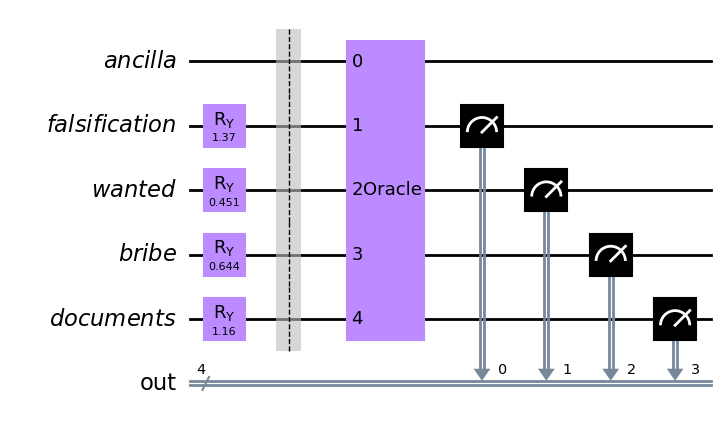

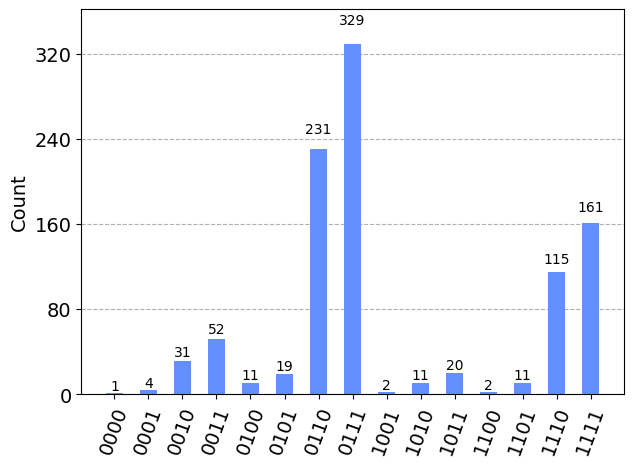

In [34]:
qubits = [false_info, wanted, bribe, all_documents]

inputs = Inputs(*qubits, probabilities=[40, 5, 10, 30])
inputs.prepare()

checker = Check(*qubits)
checker.prepare(bit_string="1000")

algorithm = QPP(*qubits, generator=inputs.get_circuit(), checker=checker.get_circuit())
algorithm.add_measurement()
algorithm.show()
results = algorithm.measure()
#results = algorithm.measure(backend=ibm_backend) #use this to run on IBMQ

In [38]:
evaluate_results(shots, ['false_info', 'wanted', 'bribe', 'all_documents'], results['results'])

false_info ~60.0%
wanted ~95.0%
bribe ~88.0%
all_documents ~32.0%


Once our hidden_string is $1000$ and the correct output is $1111$, it's normal to have the inverse probabilities. At this instance, we had:

```
false_info ~60.0%
wanted ~95.0%
bribe ~88.0%
all_documents ~32.0%
```

and the required probabilities were: [40, 5, 10, 30]. You can see that the first three data points frequencies are flipped, it's because the action of the phase oracle, which are mapping $0$ from the hidden string to $1$ in the output. So every time that we have $0$ in the query, it's counted as correct, so the probability of have $0$ is the final frequency showed above. Only the last qubit has the same frequency as its probability of $1$ since the oracle isn't flipping $0$ to $1$.


---

Beyond the last example, we could also set some daily rules. For instance, let's check how it could look a day that foreigners are not allowed

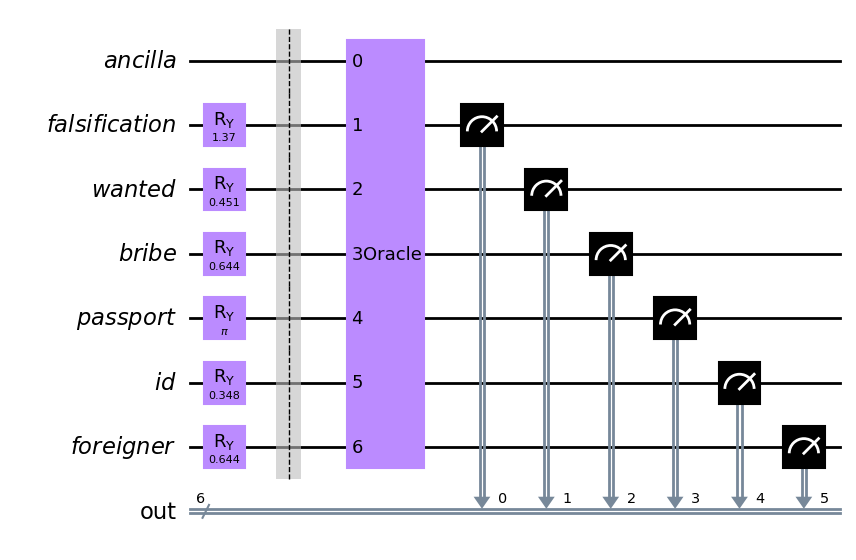

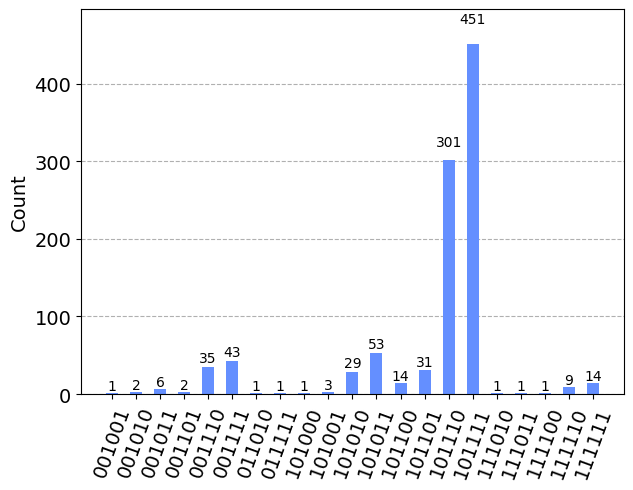

false_info ~61.0%
wanted ~95.0%
bribe ~90.0%
passport ~100.0%
person_id ~3.0%
foreigner ~91.0%


In [40]:
passport = QuantumRegister(1, name="passport")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")
person_id = QuantumRegister(1, name="id")
foreigner = QuantumRegister(1, name="foreigner")

qubits = [false_info, wanted, bribe, passport, person_id, foreigner]

inputs = Inputs(*qubits, probabilities=[40, 5, 10, 100, 3, 10])
inputs.prepare()

checker = Check(*qubits)
checker.prepare(bit_string="011000")

algorithm = QPP(*qubits, generator=inputs.get_circuit(), checker=checker.get_circuit())
algorithm.add_measurement()
algorithm.show()
results = algorithm.measure()

evaluate_results(shots, ['false_info', 'wanted', 'bribe', 'passport', 'person_id', 'foreigner'], results['results'])

---

# Final considerations

Now, we reached the end, feel free to change and test some code here.

If you enjoyed, consider to give me a [follow](https://github.com/Dpbm/) and/or a [star on github](https://github.com/Dpbm/QPapersPlease).\
In case you found a bug, a misconception, a misspelling, or something else, open a issue on the [github repo](https://github.com/Dpbm/QPapersPlease).

And for now.

Thanks for being here 🤗